# Empirical analysis of PR-AUC
- Exploration of PR curve and AUPRC by generating different case studies
- Build intuition using figures of how PR maps stuff and how the underlying distributions look like
- Ablations on PRAUC invariances

## 0. Data
- Generate binary classification data
- Draw prediction probabilities from uniform or normal distributions
- Functionality to play around with positioning of classes (overlap, scale, shift)

## 1. Underlying Metrics

- PR curve is plotted on two dimensions: TPR (recall) and PPV (precision)
- Here we explore the metrics and their relationship
- Given that multi-class is just an aggregation of multiple binary cases, I will talk about this in the binary setting
- Will be using binary terminology (e.g for detection): identified (TP), missed (FN), rejected (TN), false alarm (FP)
- All ground truth positives are either correctly identified or missed -> P = TP + FN
- All predicted positives are either true positives or false positives -> PP = TP + FP


### PPV

- Precision, the quality of predictions. Does not take into consideration how many are not detected.
- Precision is a metric based on predicted positives, not the entire positive class like recall
- Can be seen as accuracy conditioned on predicted positives e.g predicted class specific accuracy
- Unlike Recall, Precision is sensitive to class imabalances. The higher the imbalance the more FP will be, thus precision will get dragged down

$$ PPV = \frac{TP}{TP+FP} = \frac{TP}{PP}$$


### TPR

- True positive rate (recall) is a measure of how much a classifier can detect (not the quality), or in other words how many things are not missed
- I an simplified case one can construe this as being the capacity/ability of a model e.g how many patterns it can learn
- We want to maximise this*. Has a trivial maximum by predicting everything as positive.

$$ TPR = \frac{TP}{TP+FN} = \frac{TP}{P}$$

- Missed positives = False Negatives
- TP/P can also be seen as the accuracy on ground truth positives TPR = $P(\hat{y} | y=1)$ e.g class specific accuracy
- Recall is not sensitive to calss imbalance, as it is a measure derived from observation from only a single class


### Relationship
- Precision focuses on how trustworthy a detection is; it links to Type I errors
- Recall focuses on how much the classifier can detect; it links to Type II erros
- Because they focus on different things it is possible to find a classifier with both high precision and recall
- However in practice there is a trade-off wrt the threshold
- Precision is class imbalance sensitive, while recall is not

## 1.1 Increasingly overlapping classes
- Decision threshold stays fixed, dataset changes
- See how TPR and PPV change as we progressively move the two classes together
- Both decrease at a similar pace as more mingled the classes become

## 1.2 Different Thresholds
- For low thresholds we get a maximum recall (TPR) since we are not missing any positives; however the precision on those predictions is quite bad
- For high thresholds we get high precision (PPV) since we detect only the most extreme positive cases; a lot of positives are missed so recall is low
- The more we increase the threshold the better PPV gets, as we are reducing the amount of negatives, and thus false positives
- Recall starts at the maximum, since none of the positives are missed, and stays maximised until we reach the positive class support. After that point we start missing positives so recall will decrease.
- Whenever there is a gap in support the metrics will be the same for nearby thresholds -> Flat areas in the metric plots.
- If there is a clean separation between classes we can get max precision and recall, for any threshold in that gap
- TPR starts decreasing only when we reach the support of the positive class
- PPV stops increasing only when we passed the support of the negative class
- Notice: Precision and Recall have an asymmetry. Recall reaches 0 after we pass the positive class; Precision is never zero, starts off at class ratio
- In the range of the intersection between classes, precision and recall move in opposite directions
- Notice: The rate at whcih PPV/TPR move depends on the density of predictions
    - See uniform vs normal; for uniform classes the metrics linearly decrease, since the same amount of observations of re-classified at regular intervals. 
- Notice: for calss imbalances precision has more variance


## 2. PR Curve
- Plots Precision against Recall
- Insead of seeing it like a 2D plot on can interpret it as a function of precision given recall
    - e.g how much precision do I get for a chosen, tolerable recall
- Thresholds: While we can still think of the sliding threshold which produces the metrics, the thresholding values are not visible
  - We can plot the PR curve as a scatterplot and color points based on threshold
  - Looking at the color we see that the curve goes "backwards": low thresholds appear on the right where Recall is high.
  - If any two thresholds produce the same metric values, they will collapse to the same point in the roc plot
  - If two similar thresholds produce very different metric values we will see large gaps between points
- Flat areas: The previously seen flat areas for individual metrics are now either horizontal or vertical:
  - Vertical: Recall stays the same but Precision changes -> The area "before" the positive class; None of the positives are missed (max TPR) but a lot of false alarms
  - Horizontal: Precision stays constant means we passed the support of the negative class; for any threshold we detect only positives
- X-axis
  - As with any plot, the x-axis defines where we are looking and how we traverse that
  - A problem with having the decision threshold as the x-axis would be that it is not invariant to the location/scale of predictions
  - A lot of different thresholds produce the same metrics. Can we prefer a classifier over another knowing a lot of more thresholds are redundant?
  - In the end we don't necessarily care about the individual thresholds but rather the unique situations (metrics) they produce.
  - By looking from the perspective of recall we ground our expectation that only unique recall values matter, and not unqiue decision thresholds
  - By looking at all possible recalls we traverse the space of decision thresholds non-linearly, squeezing and expanding the threshold dimension
  - Why recall? Recall is computed based only on the true positive class - the one we only really care about in a detection setting. 
  - 1) By iterating over recalls we effectively traverse the threshold space only over the support of the positive class.
  - Recall is a ratio of elements of the same class. Traversing recall linearly means we always step over the same amount of observations -> regardless of how the class distribution is. 
  - 2) Having recall as the x-axis allows us to traverse the support of the positive class at a constant pace (nr of observations).
- PR bias
  - Having recall as the x-axis means it ignores the region with only negative samples (map to the same recall value)
  - We basically zoom in where we have the most positive observations.
  - This region of interest contains two cases: the intersection of classes and the support exclusive to the positive class
  - Precision is high when we don't have many negative observation past threshold, maximised in the exclusive positive zone
  - Precision is compromised in the region where classes intersect
  - The size class overlap in terms of support (or nr of unique thresholds) does not matter. The densitiy of the positive class does
  - PRC is biased towards the region with most positive samples. If in that region we have good precision we will get a high area under the curve.
  - Y-axis is predicated not only on class overlap but also class ratio.
- Shape 
  - If there is a clean separation between classes the PRC curve will be flat and maximised
  - A blurr/mix of classes produces a declining curve, the higher the mass in the intersection the steeper
  - Unlike ROC, the worse case scenatio is not a diagonal; it can be a flat horizontal line dictaded by the class imbalance
- Class Imbalance
  - If the two classes completely overlap (same distribution) then precision for any threshold is the class ratio
  - While the x-axis is not impacted by class imbalance, the y-axis does -> for the same distribution of potive observations we can get different AUCs depending on the number of negatives.
  
## 3. AUPRC
- Area under the PR curve
- Eexplore some invariances of the AUROC wrt the underlying data
- PRC bias: zooms in regions with most positive mass; looks at what precision we get there
- We empirically confirm what we know having recall as an x-axis - it is invariant to where the positive class is: location, scale
- The size of the class overlap (measure in #obs, not support) has a big impact on AUPRC since it impacts where we look at (recall zooms in on that) and the precision we get there
- Precision is sensitive to class impbalance so AURPC reflects that

### 3.1 Scale Invariance
- We can shrink the support of the dataset/predictions and see if AUPRC changes
- AUPRC is scale invariant
- All "extra" thresholds will map to the same PPV and TPR anyways, so the PR curve will remain unchanged

### 3.2 Shift Invariance
- We can shift the predictions e.g squeeze them all into [0.5, 1]
- AUPRC is shift invariant
- Similar to scale invariance, it doesn't really matter where the prediction interval is located, all thresholds left and right of the negative class support will collapse to a single point respectively on the curve; all other thresholds will produce PPV and TRPs that have been seen before as all the ratios are the same

### 3.3. Class Boundary and Margin Sensitivity
- How sensitive is AUPRC to different degrees of predictions overlapping
- When there is a clear separation between classes e.g a wide margin, then AUPRC maxes out since for all relevant thresholds (over the positive class) we always get max precision
- If a lot of positive mass is in the intersection then that region is being zoomed in
- Any decision threshold within the intersection will impact precision
- AUPRC is senstive to the class intersectino proportional to the ratio of positive elements in it; but also to how many negatives we get there (class imbalance matters)

### 3.4 Class Imbalance
- AUROC is sensitive to class imbalances
- The x-axis, which defines where we zoom in, does not take class imbalance into account.
- However at any point precision will be lower the more negatives there are; the higher the imbalance the higher the number of FPs.

## 4. Limitations
- Because AURPC is sensitive to both size of overlap and class ratio we can find situations that are structurally different but cannot be distinguished in terms of score
- Eg. high overlap with low class imbalance vs low overlap with high class imbalance

# 5. Conclusion
- AUROC provides an expected precision over all splits of the positive class
- The underlying metric PPV, is senstive to class imbalance
- The underlying axis TPR, zooms in on regions with most positive densitiy
- AUROC is invariant to location, size or shape of the positive class
- AUROC is sensitive how much predictions overlap and class imbalance

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as sk_metrics
%config Completer.use_jedi = False

## 0. Data
- Generate binary classification data
- Draw prediction probabilities from uniform or normal distributions
- Functionality to play around with positioning of classes (overlap, scale, shift)

In [2]:
def get_data(boundary=0.5, overlap=0.5, class_ratio=0.5, scale=1, shift=0, n_obs=200, dist="uniform") -> pd.DataFrame:
    """
    Generate binary classification data, predictions drawn from uniform or normal distributions
    :param boundary: where the true boundary between the classes should be; can change depending on scale and shift
    :param overlap: percentage of how much the two classes should overlap, can be negative to get a wider margin
    :param class_ratio: to play with class imbalances, refers to primary class (1)
    :param scale: In (0, 1], shrinks support to leave more space on the sides for thresholding; remains centered around the boundary
    :param shift: Move support, works only if support scaled down as it will remain in [0,1]
    :param dist: distribution to draw predictions from - either uniform or normal
    """
    n_pos = int(n_obs * class_ratio)
    n_neg = int(n_obs * (1 - class_ratio))
    eps = 1e-2
    
    dist = np.random.uniform if dist == "uniform" else np.random.standard_normal
    pos = _rescale(dist(size=n_pos), min_=boundary - overlap/2 + eps, max_=1)
    neg = _rescale(dist(size=n_neg), min_=0, max_=boundary + overlap/2 - eps)
    preds = np.concatenate([pos, neg])
    y = [1] * n_pos + [0] * n_neg
    
    scale = min(abs(scale), 1)
    preds = preds * scale + boundary * (1 - scale)
    
    shift = max(shift, -min(preds)) if shift < 0 else min(shift, (1-max(preds)))
    preds += shift
    
    res = pd.DataFrame({"preds": preds, "y": y})
    return res


def _rescale(s: pd.Series, min_: float, max_: float):
    s = (s - s.min()) / (s.max() - s.min())
    s = (max_ - min_) * s + min_
    return s


def plot_data(data, ax=None, title=None, dist="uniform"):
    """
    Plot as a filled histogram, each bar shows the class distribution for bin
    """
    if dist == "uniform":
        ax = sns.histplot(data=data, x="preds", hue="y", bins=20, binrange=(0, 1), multiple="fill", ax=ax)
    else:
        ax = sns.kdeplot(data=data, x="preds", hue="y", ax=ax, bw_adjust=0.7, cut=0.1, fill=True)
    ax.set_xlim(0, 1)
    ax.set_title(title)
    

Uniform


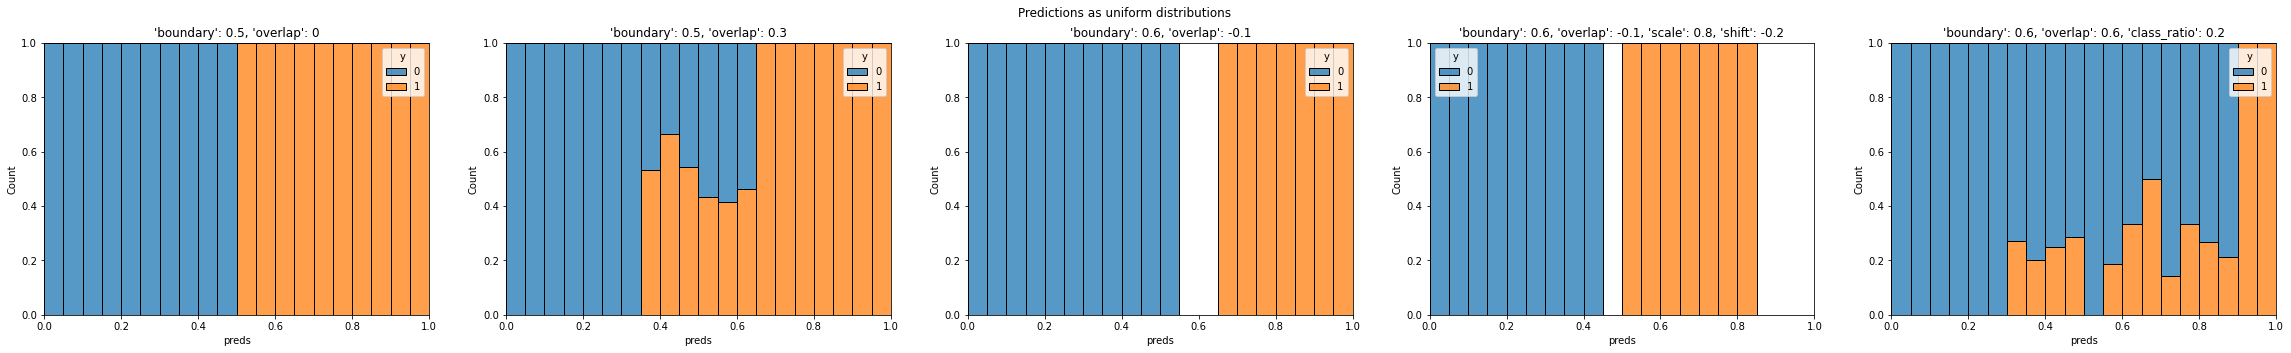

Normal


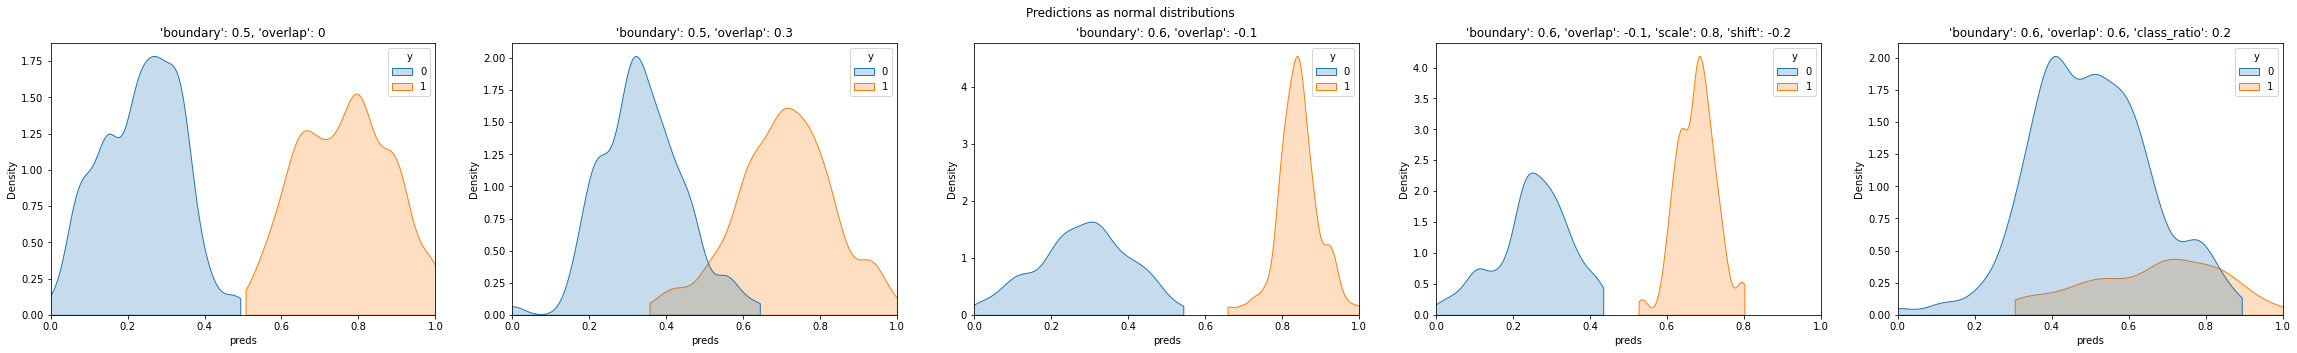

In [3]:
examples = [
        {"boundary": 0.5, "overlap": 0},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.6, "overlap": -0.1},
        {"boundary": 0.6, "overlap": -0.1, "scale": 0.8, "shift": -0.2},
        {"boundary": 0.6, "overlap": 0.6, "class_ratio": 0.2},
    ]
print("Uniform")
fig0, axarr = plt.subplots(1, len(examples), figsize=(40,5))
plt.suptitle("Predictions as uniform distributions")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[ix], title=str(params)[1:-1], dist="uniform")
plt.show()
    
print("Normal")
fig, axarr = plt.subplots(1, len(examples), figsize=(40,5))
plt.suptitle("Predictions as normal distributions")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[ix], title=str(params)[1:-1], dist="normal")
plt.show()


## 1. Underlying Metrics

- PR curve is plotted on two dimensions: TPR (recall) and PPV (precision)
- Here we explore the metrics and their relationship
- Given that multi-class is just an aggregation of multiple binary cases, I will talk about this in the binary setting
- Will be using binary terminology (e.g for detection): identified (TP), missed (FN), rejected (TN), false alarm (FP)
- All ground truth positives are either correctly identified or missed -> P = TP + FN
- All predicted positives are either true positives or false positives -> PP = TP + FP


### PPV

- Precision, the quality of predictions. Does not take into consideration how many are not detected.
- Precision is a metric based on predicted positives, not the entire positive class like recall
- Can be seen as accuracy conditioned on predicted positives e.g predicted class specific accuracy
- Unlike Recall, Precision is sensitive to class imabalances. The higher the imbalance the more FP will be, thus precision will get dragged down

$$ PPV = \frac{TP}{TP+FP} = \frac{TP}{PP}$$


### TPR

- True positive rate (recall) is a measure of how much a classifier can detect (not the quality), or in other words how many things are not missed
- I an simplified case one can construe this as being the capacity/ability of a model e.g how many patterns it can learn
- We want to maximise this*. Has a trivial maximum by predicting everything as positive.

$$ TPR = \frac{TP}{TP+FN} = \frac{TP}{P}$$

- Missed positives = False Negatives
- TP/P can also be seen as the accuracy on ground truth positives TPR = $P(\hat{y} | y=1)$ e.g class specific accuracy
- Recall is not sensitive to calss imbalance, as it is a measure derived from observation from only a single class


### Relationship
- Precision focuses on how trustworthy a detection is; it links to Type I errors
- Recall focuses on how much the classifier can detect; it links to Type II erros
- Because they focus on different things it is possible to find a classifier with both high precision and recall
- However in practice there is a trade-off wrt the threshold
- Precision is class imbalance sensitive, while recall is not

In [15]:
def ppv(data, threshold=0.5):
    data = data.loc[data["preds"] >= threshold]
    return data["y"].mean()


def tpr(data, threshold=0.5):
    data = data.loc[data["y"] == 1]
    preds = data["preds"] >= threshold
    return (preds == data["y"]).mean()


def get_metrics(data, n_thresholds=100) -> pd.DataFrame:
    """Dataframe with all metrics and thresholds as index"""
    res = []
    for threshold in np.linspace(0, 1, n_thresholds):
        res.append({
            "threshold": threshold,
            "TPR": tpr(data, threshold),
            "PPV": ppv(data, threshold)
        })
    return pd.DataFrame(res).set_index("threshold")


data = get_data(overlap=0.2)
print(f"ppv me:{ppv(data, threshold=.5)} sklearn: {sk_metrics.precision_score(data['y'], data['preds'] >= .5)}")
print(f"tpr me:{tpr(data, threshold=.5)} sklearn: {sk_metrics.recall_score(data['y'], data['preds'] >= .5)}")


ppv me:0.8876404494382022 sklearn: 0.8876404494382022
tpr me:0.79 sklearn: 0.79


## 1.1 Increasingly overlapping classes
- Decision threshold stays fixed, dataset changes
- See how TPR and PPV change as we progressively move the two classes together
- Both decrease at a similar pace as more mingled the classes become

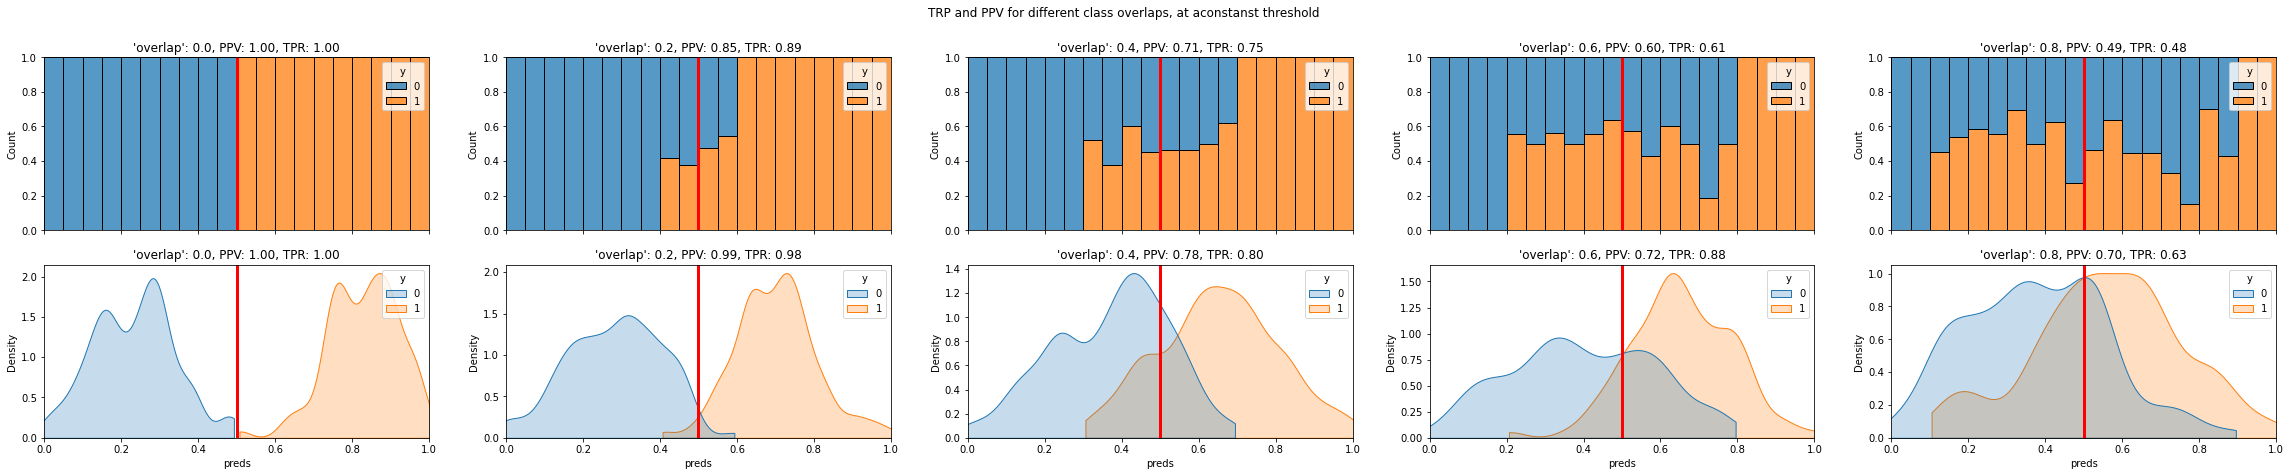

In [16]:
examples = [{"overlap": i/10} for i in range(0, 10, 2)]
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)

for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=f"{str(params)[1:-1]}, PPV: {ppv(data, threshold=.5):.2f}, TPR: {tpr(data, threshold=.5):.2f}", dist="uniform")
    axarr[0, ix].axvline(0.5, color="red", linewidth=3)
    
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[1, ix], title=f"{str(params)[1:-1]}, PPV: {ppv(data, threshold=.5):.2f}, TPR: {tpr(data, threshold=.5):.2f}", dist="normal")
    axarr[1, ix].axvline(0.5, color="red", linewidth=3)

plt.suptitle("TRP and PPV for different class overlaps, at aconstanst threshold")
plt.show()


## 1.2 Different Thresholds
- For low thresholds we get a maximum recall (TPR) since we are not missing any positives; however the precision on those predictions is quite bad
- For high thresholds we get high precision (PPV) since we detect only the most extreme positive cases; a lot of positives are missed so recall is low
- The more we increase the threshold the better PPV gets, as we are reducing the amount of negatives, and thus false positives
- Recall starts at the maximum, since none of the positives are missed, and stays maximised until we reach the positive class support. After that point we start missing positives so recall will decrease.
- Whenever there is a gap in support the metrics will be the same for nearby thresholds -> Flat areas in the metric plots.
- If there is a clean separation between classes we can get max precision and recall, for any threshold in that gap
- TPR starts decreasing only when we reach the support of the positive class
- PPV stops increasing only when we passed the support of the negative class
- Notice: Precision and Recall have an asymmetry. Recall reaches 0 after we pass the positive class; Precision is never zero, starts off at class ratio
- In the range of the intersection between classes, precision and recall move in opposite directions
- Notice: The rate at whcih PPV/TPR move depends on the density of predictions
    - See uniform vs normal; for uniform classes the metrics linearly decrease, since the same amount of observations of re-classified at regular intervals. 
- Notice: for calss imbalances precision has more variance

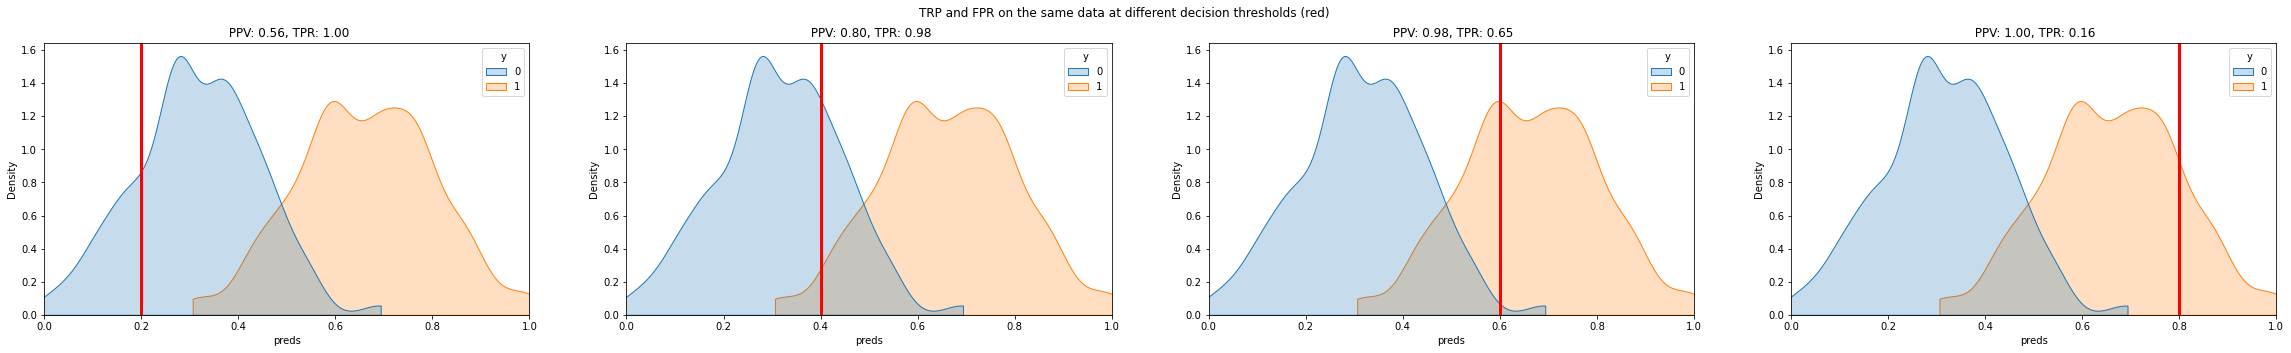

In [17]:
fig, axarr = plt.subplots(1, 4, figsize=(40,5))
data = get_data(overlap=0.4, dist="normal")
for ix, threshold in enumerate([.2, .4, .6, .8]):
    plot_data(data, ax=axarr[ix], title=f" PPV: {ppv(data, threshold):.2f}, TPR: {tpr(data, threshold):.2f}", dist="normal")
    axarr[ix].axvline(threshold, color="red", linewidth=3)
plt.suptitle("TRP and FPR on the same data at different decision thresholds (red)")
plt.show()

Uniform


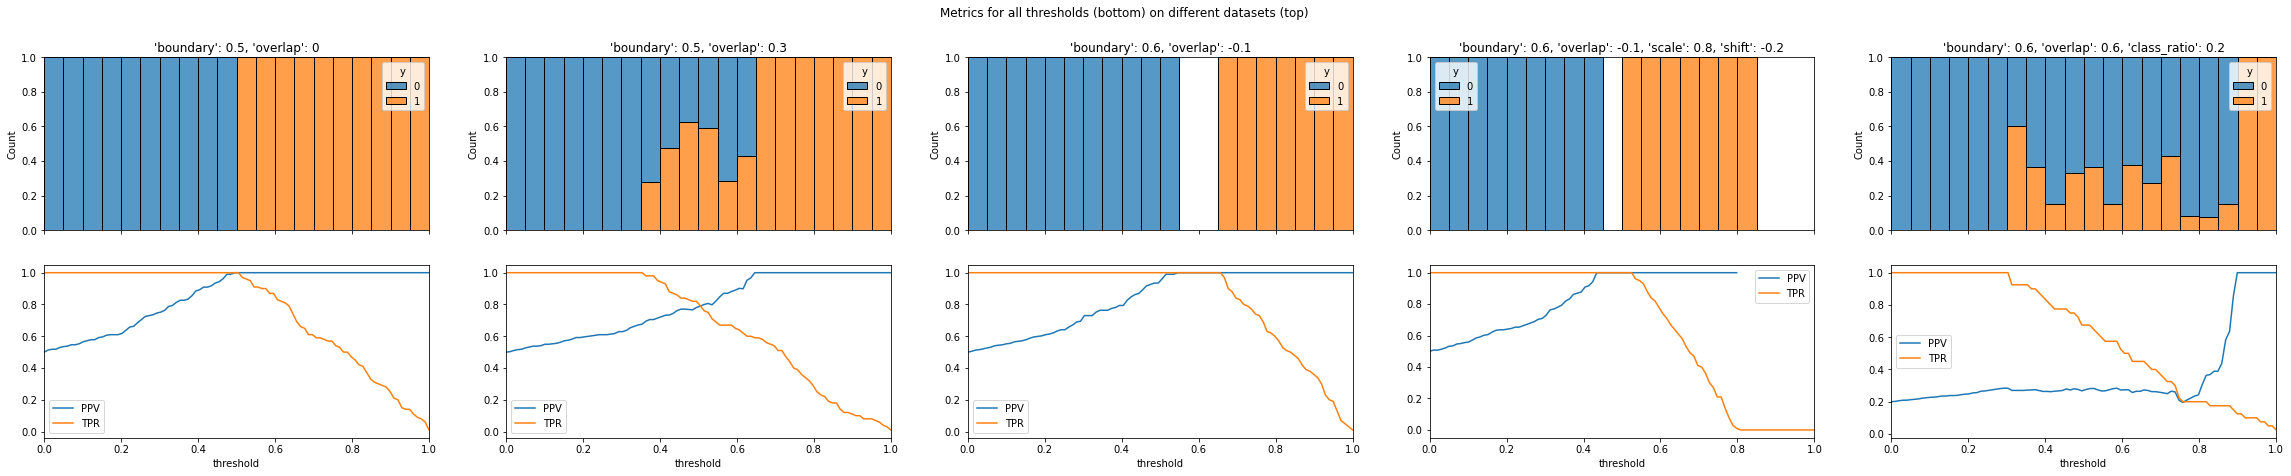

Normal


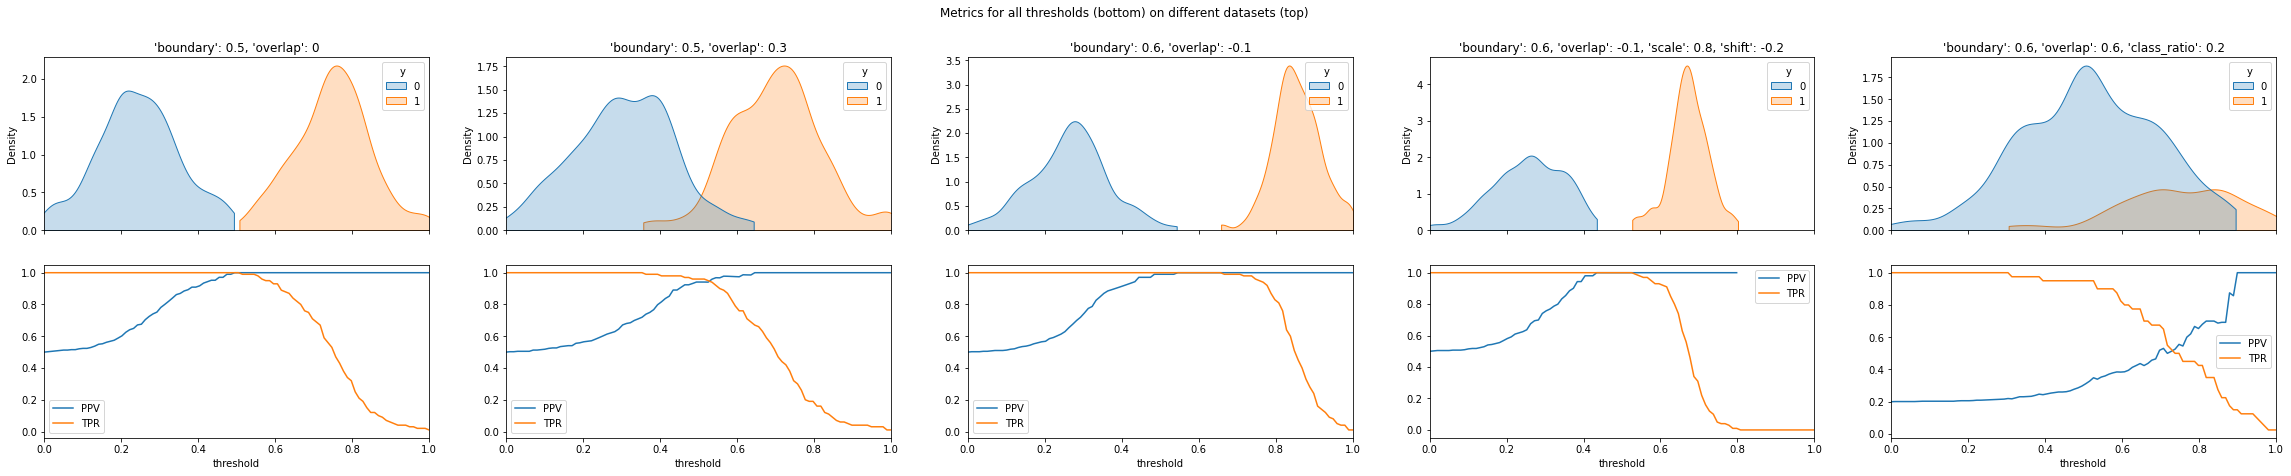

In [18]:
examples = [
        {"boundary": 0.5, "overlap": 0},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.6, "overlap": -0.1},
        {"boundary": 0.6, "overlap": -0.1, "scale": 0.8, "shift": -0.2},
        {"boundary": 0.6, "overlap": 0.6, "class_ratio": 0.2},
    ]
print("Uniform")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    get_metrics(data)[["PPV", "TPR"]].plot(ax=axarr[1, ix])
plt.show()

print("Normal")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=True)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="normal")
    get_metrics(data)[["PPV", "TPR"]].plot(ax=axarr[1, ix])
plt.show()

## 2. PR Curve
- Plots Precision against Recall
- Insead of seeing it like a 2D plot on can interpret it as a function of precision given recall
    - e.g how much precision do I get for a chosen, tolerable recall
- Thresholds: While we can still think of the sliding threshold which produces the metrics, the thresholding values are not visible
  - We can plot the PR curve as a scatterplot and color points based on threshold
  - Looking at the color we see that the curve goes "backwards": low thresholds appear on the right where Recall is high.
  - If any two thresholds produce the same metric values, they will collapse to the same point in the roc plot
  - If two similar thresholds produce very different metric values we will see large gaps between points
- Flat areas: The previously seen flat areas for individual metrics are now either horizontal or vertical:
  - Vertical: Recall stays the same but Precision changes -> The area "before" the positive class; None of the positives are missed (max TPR) but a lot of false alarms
  - Horizontal: Precision stays constant means we passed the support of the negative class; for any threshold we detect only positives
- X-axis
  - As with any plot, the x-axis defines where we are looking and how we traverse that
  - A problem with having the decision threshold as the x-axis would be that it is not invariant to the location/scale of predictions
  - A lot of different thresholds produce the same metrics. Can we prefer a classifier over another knowing a lot of more thresholds are redundant?
  - In the end we don't necessarily care about the individual thresholds but rather the unique situations (metrics) they produce.
  - By looking from the perspective of recall we ground our expectation that only unique recall values matter, and not unqiue decision thresholds
  - By looking at all possible recalls we traverse the space of decision thresholds non-linearly, squeezing and expanding the threshold dimension
  - Why recall? Recall is computed based only on the true positive class - the one we only really care about in a detection setting. 
  - 1) By iterating over recalls we effectively traverse the threshold space only over the support of the positive class.
  - Recall is a ratio of elements of the same class. Traversing recall linearly means we always step over the same amount of observations -> regardless of how the class distribution is. 
  - 2) Having recall as the x-axis allows us to traverse the support of the positive class at a constant pace (nr of observations).
- PR bias
  - Having recall as the x-axis means it ignores the region with only negative samples (map to the same recall value)
  - We basically zoom in where we have the most positive observations.
  - This region of interest contains two cases: the intersection of classes and the support exclusive to the positive class
  - Precision is high when we don't have many negative observation past threshold, maximised in the exclusive positive zone
  - Precision is compromised in the region where classes intersect
  - The size class overlap in terms of support (or nr of unique thresholds) does not matter. The densitiy of the positive class does
  - PRC is biased towards the region with most positive samples. If in that region we have good precision we will get a high area under the curve.
  - Y-axis is predicated not only on class overlap but also class ratio.
- Shape 
  - If there is a clean separation between classes the PRC curve will be flat and maximised
  - A blurr/mix of classes produces a declining curve, the higher the mass in the intersection the steeper
  - Unlike ROC, the worse case scenatio is not a diagonal; it can be a flat horizontal line dictaded by the class imbalance
- Class Imbalance
  - If the two classes completely overlap (same distribution) then precision for any threshold is the class ratio
  - While the x-axis is not impacted by class imbalance, the y-axis does -> for the same distribution of potive observations we can get different AUCs depending on the number of negatives.

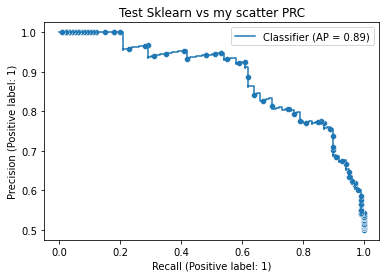

In [21]:
def plot_prc(data, n_thresholds=100, ax=None, title="", color_thresholds=True):
    metrics_df = get_metrics(data, n_thresholds=n_thresholds)
    kwargs = {"hue": "threshold", "palette": "coolwarm"} if color_thresholds else {}
    ax = sns.scatterplot(data=metrics_df, x="TPR", y="PPV", ax=ax, **kwargs)
    ax.set_title(title)
    
# test my roc and sklearn
data = get_data(overlap=0.5, dist="normal")
sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"])
plot_prc(data, color_thresholds=False)
plt.title("Test Sklearn vs my scatter PRC")
plt.show()

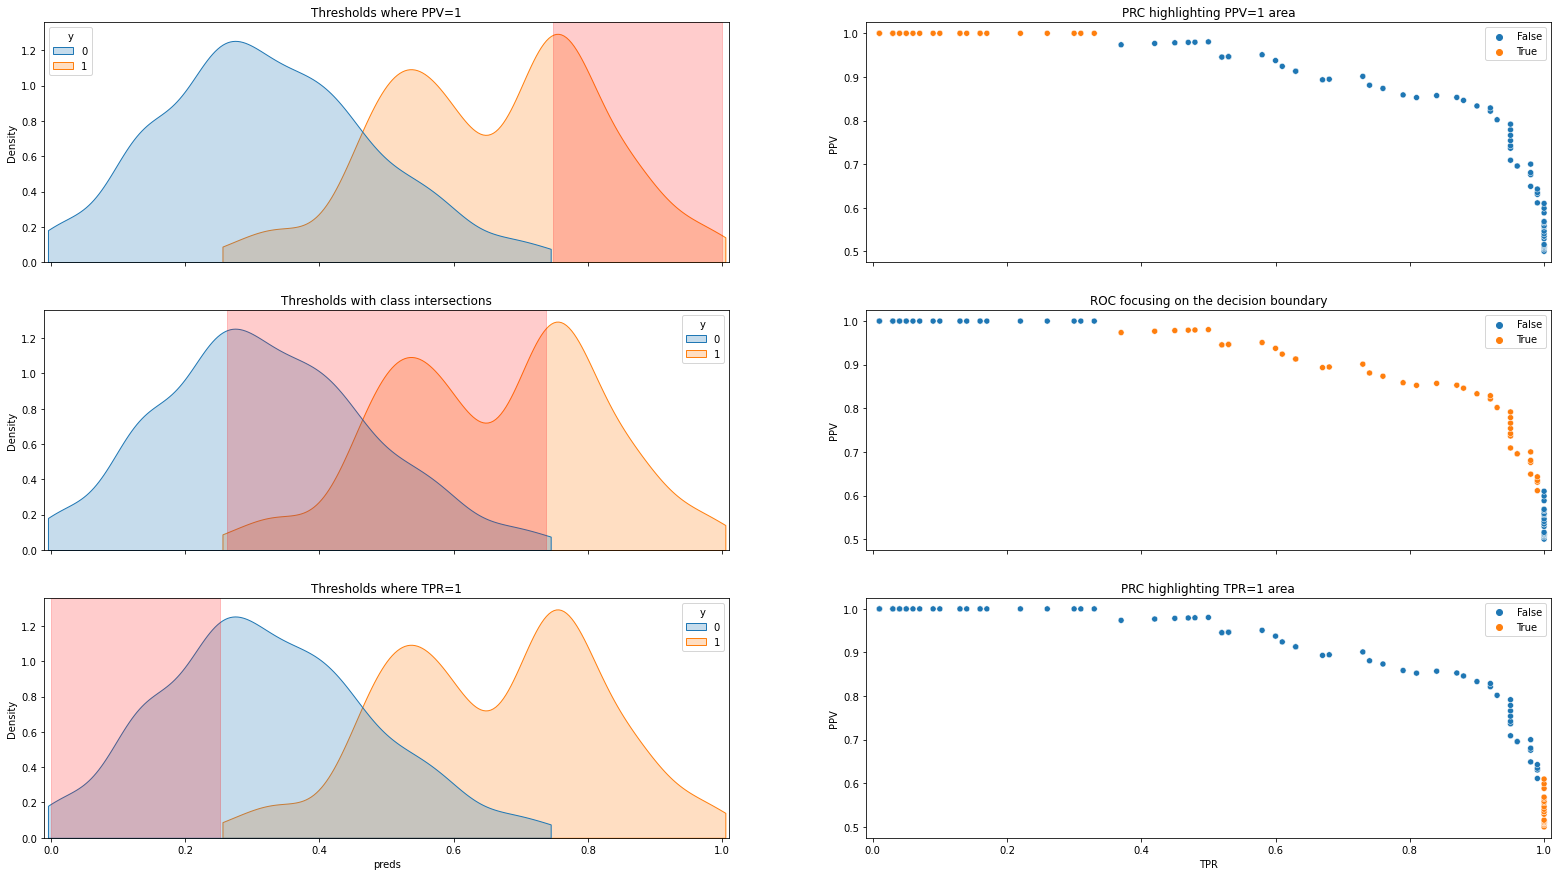

In [34]:
fig, axarr = plt.subplots(3, 2, figsize=(27, 15), sharex=True)
data = get_data(overlap=0.5, dist="normal")
metrics_df = get_metrics(data, n_thresholds=100)

ppv1_th = metrics_df.query("PPV == 1").index
plot_data(data, ax=axarr[0, 0], title="Thresholds where PPV=1", dist="normal")
axarr[0, 0].axvspan(ppv1_th.min(), ppv1_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="TPR", y="PPV", hue=metrics_df.index.isin(ppv1_th) , ax=axarr[0, 1])
axarr[0, 1].set_title("PRC highlighting PPV=1 area")

mid_th = metrics_df.query("PPV < 1").query("TPR < 1").index
plot_data(data, ax=axarr[1, 0], title="Thresholds with class intersections", dist="normal")
axarr[1, 0].axvspan(mid_th.min(), mid_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="TPR", y="PPV", hue=metrics_df.index.isin(mid_th) , ax=axarr[1, 1])
axarr[1, 1].set_title("ROC focusing on the decision boundary")

tpr1_th = metrics_df.query("TPR == 1").index
plot_data(data, ax=axarr[2, 0], title="Thresholds where TPR=1", dist="normal")
axarr[2, 0].axvspan(tpr1_th.min(), tpr1_th.max(), alpha=0.2, color="red")
sns.scatterplot(data=metrics_df, x="TPR", y="PPV", hue=metrics_df.index.isin(tpr1_th) , ax=axarr[2, 1])
axarr[2, 1].set_title("PRC highlighting TPR=1 area")

plt.xlim(-0.01, 1.01)
plt.show()

Normal


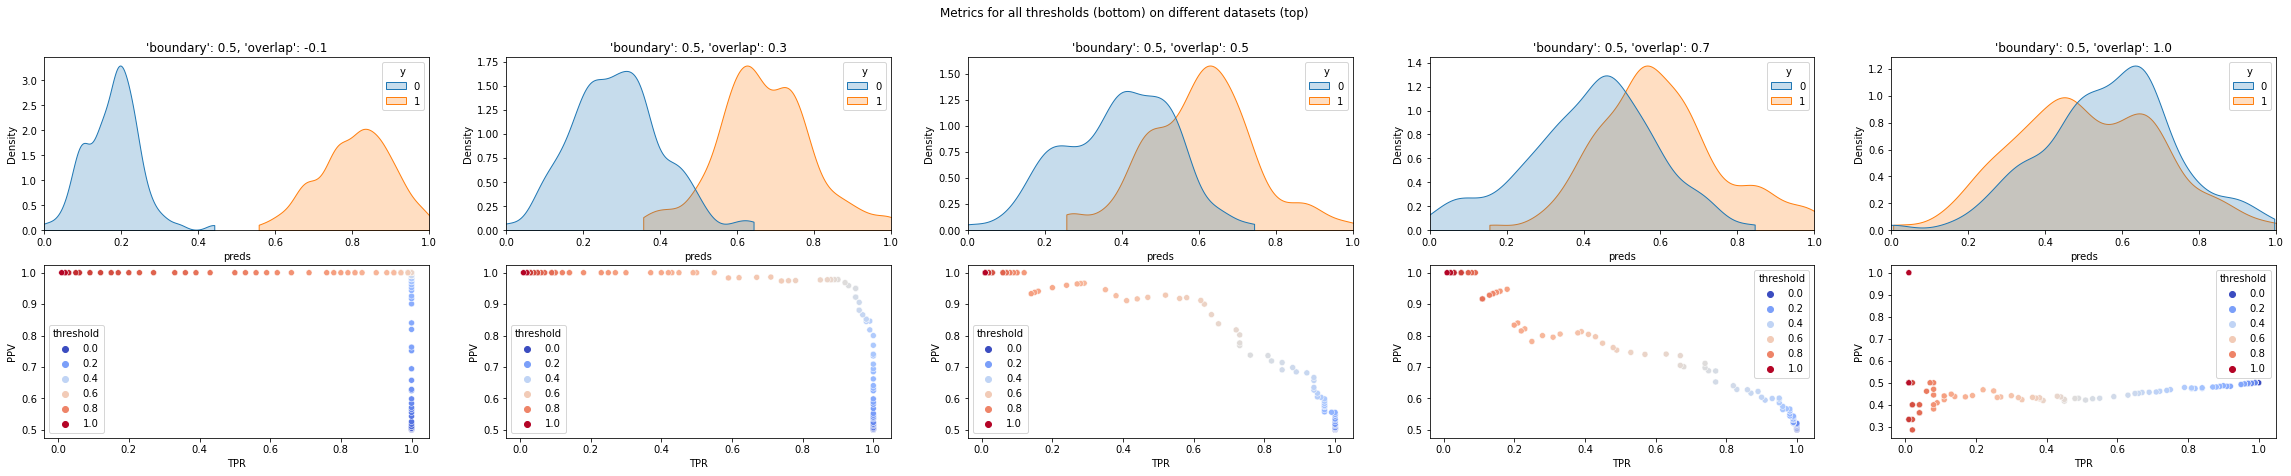

In [46]:
examples = [
        {"boundary": 0.5, "overlap": -0.1},
        {"boundary": 0.5, "overlap": 0.3},
        {"boundary": 0.5, "overlap": 0.5},
        {"boundary": 0.5, "overlap": 0.7},
        {"boundary": 0.5, "overlap": 1.0},
    ]

print("Normal")
fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Metrics for all thresholds (bottom) on different datasets (top)")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="normal")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="normal")
    plot_prc(data, ax=axarr[1, ix])
plt.show()

## 3. AUPRC
- Area under the PR curve
- Eexplore some invariances of the AUROC wrt the underlying data
- PRC bias: zooms in regions with most positive mass; looks at what precision we get there
- We empirically confirm what we know having recall as an x-axis - it is invariant to where the positive class is: location, scale
- The size of the class overlap (measure in #obs, not support) has a big impact on AUPRC since it impacts where we look at (recall zooms in on that) and the precision we get there
- Precision is sensitive to class impbalance so AURPC reflects that

### 3.1 Scale Invariance
- We can shrink the support of the dataset/predictions and see if AUPRC changes
- AUPRC is scale invariant
- All "extra" thresholds will map to the same PPV and TPR anyways, so the PR curve will remain unchanged

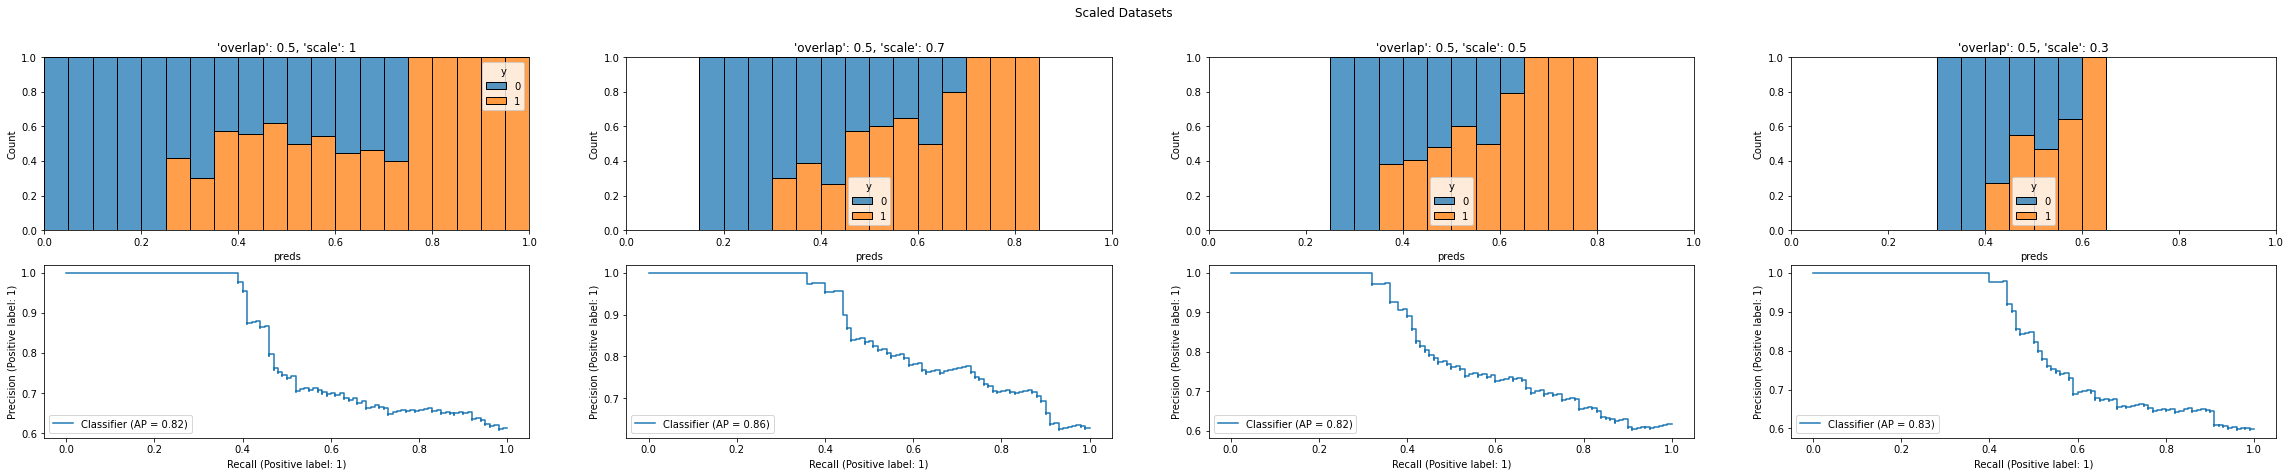

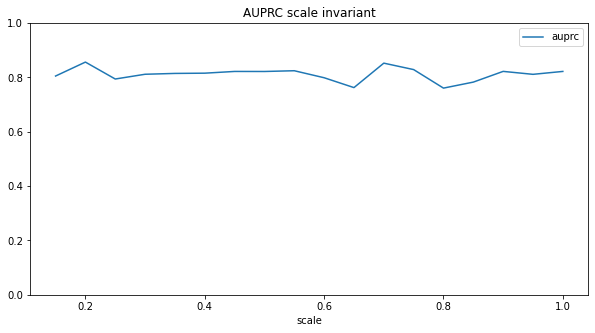

In [39]:
examples = [{"overlap": 0.5, "scale": i} for i in [1, 0.7, 0.5, 0.3]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Scaled Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for scale in np.arange(1, 0.1, -0.05):
    data = get_data(overlap=0.5, scale=scale, dist="uniform")
    res.append({
        "scale": scale, 
        "auprc": sk_metrics.average_precision_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("scale").plot(figsize=(10, 5), ylim=(0, 1), title="AUPRC scale invariant")
plt.show()

### 3.2 Shift Invariance
- We can shift the predictions e.g squeeze them all into [0.5, 1]
- AUPRC is shift invariant
- Similar to scale invariance, it doesn't really matter where the prediction interval is located, all thresholds left and right of the negative class support will collapse to a single point respectively on the curve; all other thresholds will produce PPV and TRPs that have been seen before as all the ratios are the same

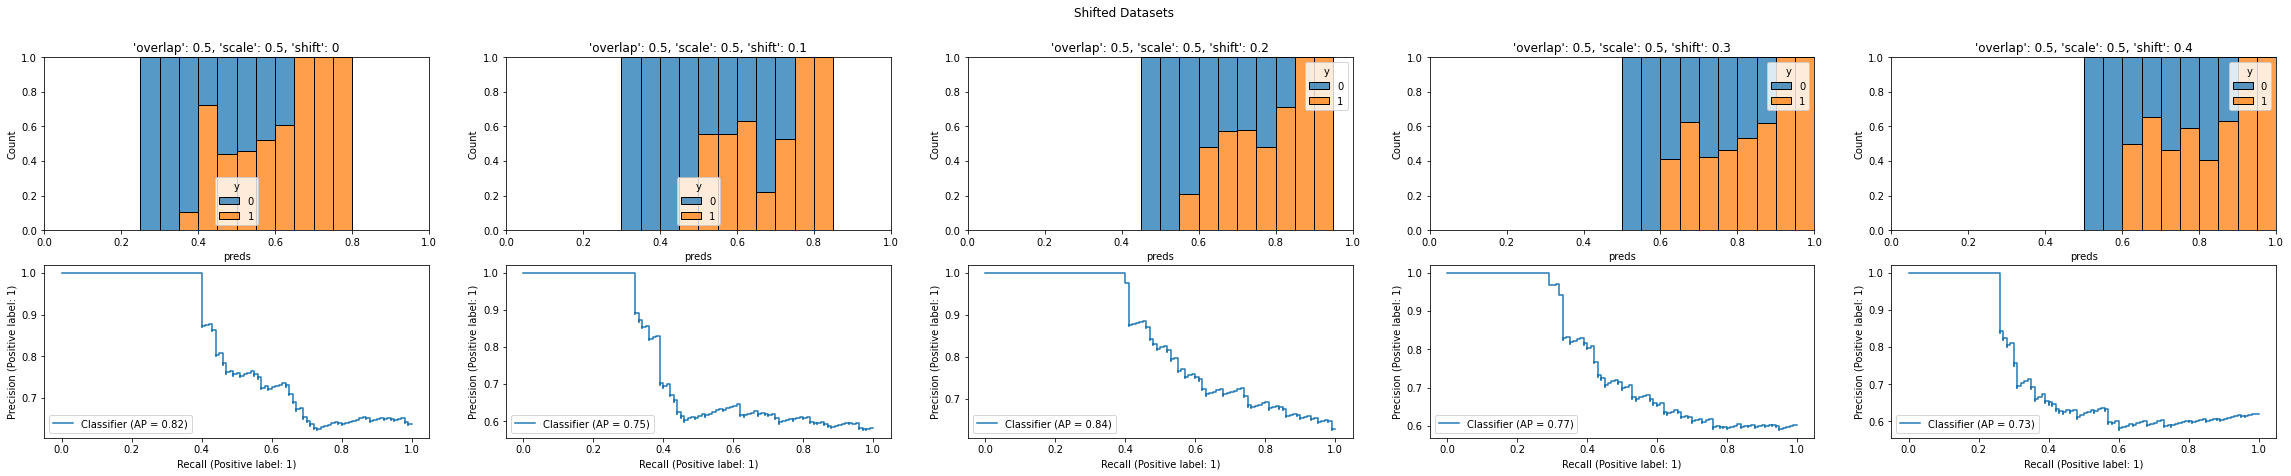

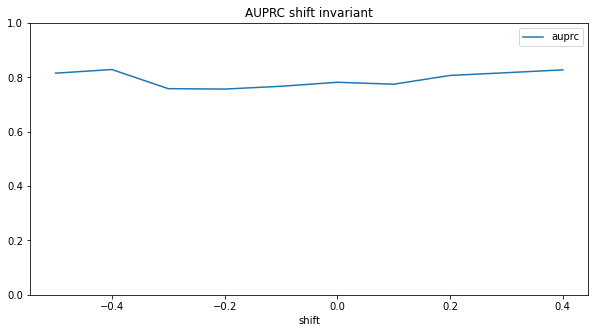

In [41]:
examples = [{"overlap": 0.5, "scale": 0.5, "shift": i} for i in [0, .1, .2, .3, .4]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Shifted Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for shift in np.arange(-0.5, 0.5, 0.1):
    data = get_data(overlap=0.5, scale=0.5, shift=shift, dist="uniform")
    res.append({
        "shift": shift, 
        "auprc": sk_metrics.average_precision_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("shift").plot(figsize=(10, 5), ylim=(0, 1), title="AUPRC shift invariant")
plt.show()

### 3.3. Class Boundary and Margin Sensitivity
- How sensitive is AUPRC to different degrees of predictions overlapping
- When there is a clear separation between classes e.g a wide margin, then AUPRC maxes out since for all relevant thresholds (over the positive class) we always get max precision
- If a lot of positive mass is in the intersection then that region is being zoomed in
- Any decision threshold within the intersection will impact precision
- AUPRC is senstive to the class intersectino proportional to the ratio of positive elements in it; but also to how many negatives we get there (class imbalance matters)

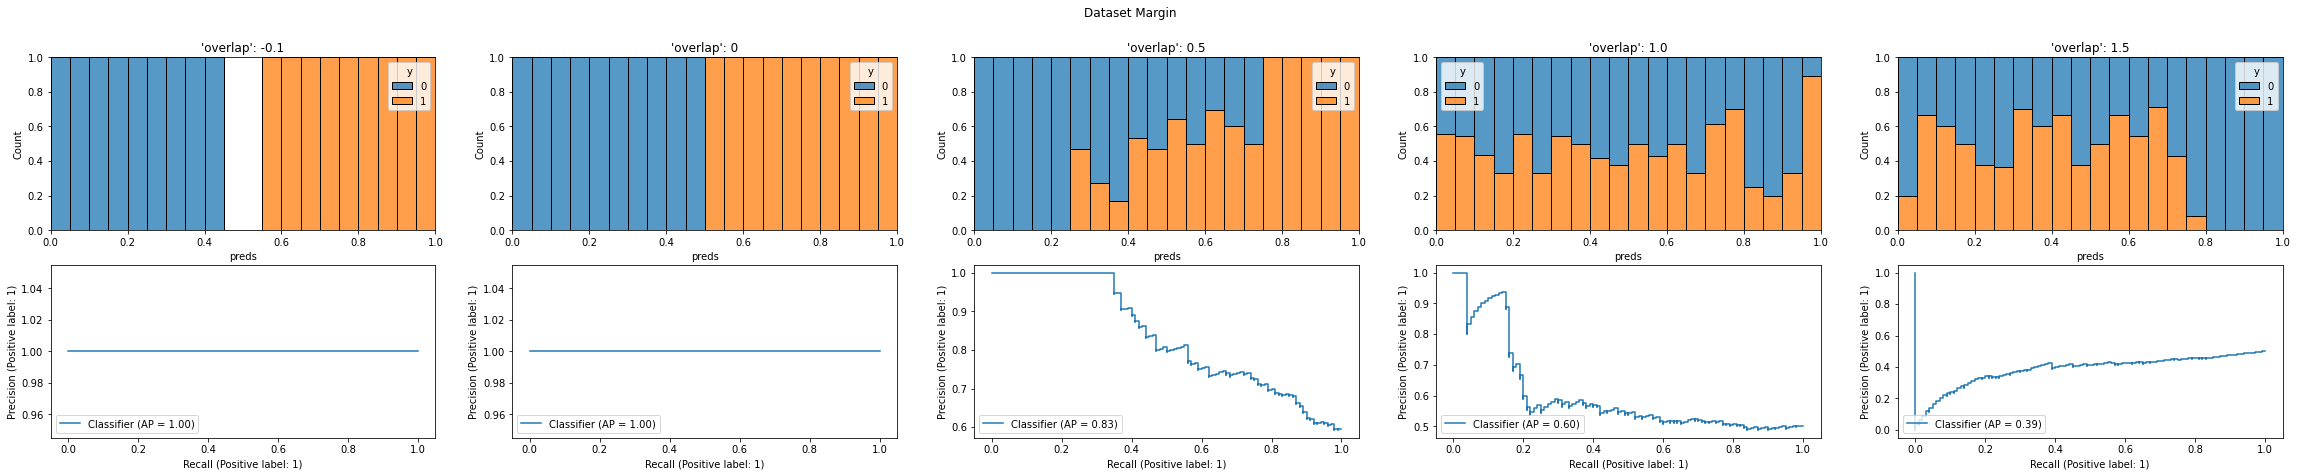

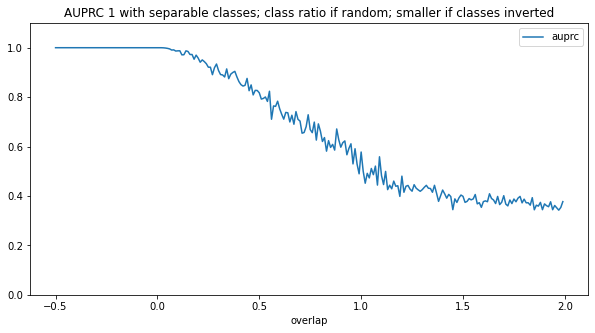

In [47]:
examples = [{"overlap": i} for i in [-0.1, 0, 0.5, 1.0, 1.5]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Dataset Margin")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for overlap in np.arange(-0.5, 2, 0.01):
    data = get_data(overlap=overlap, dist="uniform")
    res.append({
        "overlap": overlap, 
        "auprc": sk_metrics.average_precision_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("overlap").plot(figsize=(10, 5), ylim=(0, 1.1), title="AUPRC 1 with separable classes; class ratio if random; smaller if classes inverted")
plt.show()

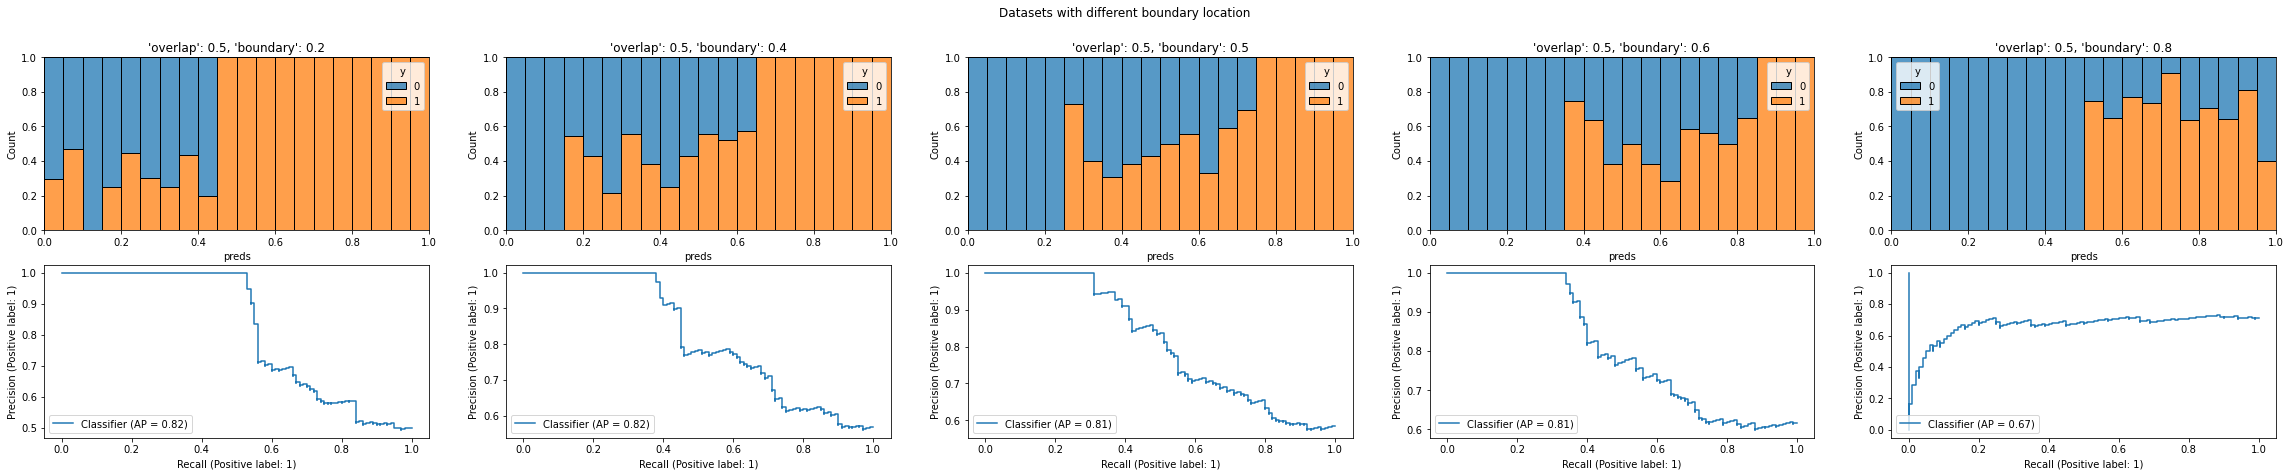

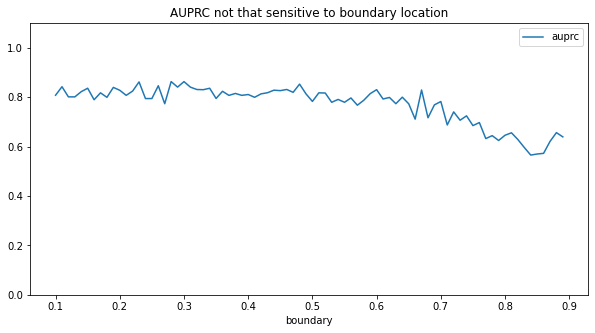

In [52]:
examples = [{"overlap": 0.5, "boundary": i} for i in [.2, .4, .5, .6, .8]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Datasets with different boundary location")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for boundary in np.arange(0.1, 0.9, 0.01):
    data = get_data(boundary=boundary, overlap=0.5, dist="uniform")
    res.append({
        "boundary": boundary, 
        "auprc": sk_metrics.average_precision_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("boundary").plot(figsize=(10, 5), ylim=(0, 1.1), title="AUPRC not sensitive to boundary location")
plt.show()

### 3.4 Class Imbalance
- AUROC is sensitive to class imbalances
- The x-axis, which defines where we zoom in, does not take class imbalance into account.
- However at any point precision will be lower the more negatives there are; the higher the imbalance the higher the number of FPs.

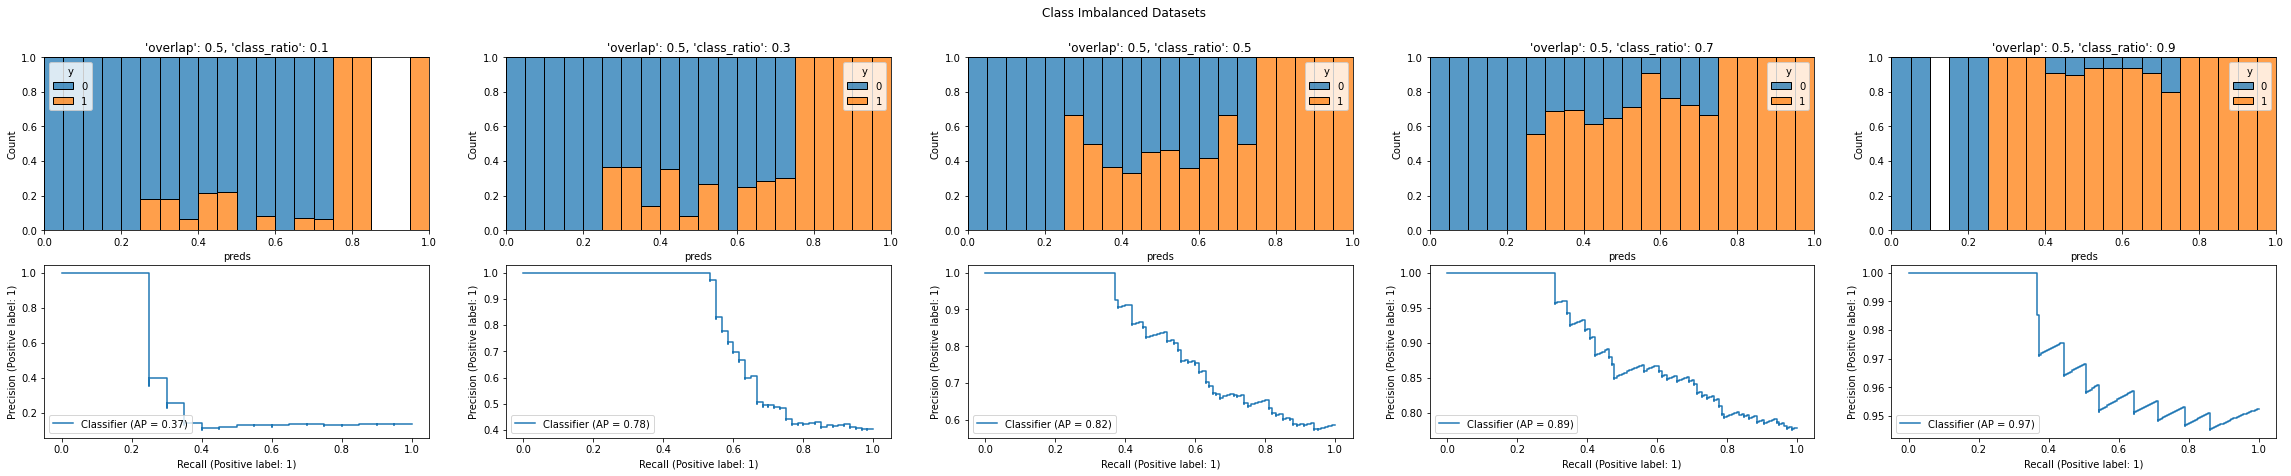

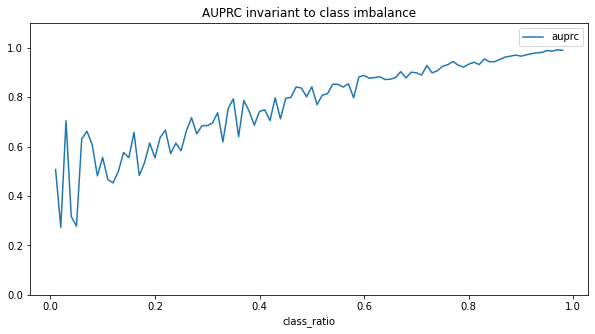

In [45]:
examples = [{"overlap": 0.5, "class_ratio" : i} for i in [.1, .3, .5, .7, .9]]

fig, axarr = plt.subplots(2, len(examples), figsize=(40,7), sharex=False)
plt.suptitle("Class Imbalanced Datasets")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


res = []
for class_ratio in np.arange(0.01, 0.99, 0.01):
    data = get_data(class_ratio=class_ratio, overlap=0.5, dist="uniform")
    res.append({
        "class_ratio": class_ratio, 
        "auprc": sk_metrics.average_precision_score(data["y"], data["preds"])
    })
pd.DataFrame(res).set_index("class_ratio").plot(figsize=(10, 5), ylim=(0, 1.1), title="AUPRC invariant to class imbalance")
plt.show()

## 4. Limitations
- Because AURPC is sensitive to both size of overlap and class ratio we can find situations that are structurally different but cannot be distinguished in terms of score
- Eg. high overlap with low class imbalance vs low overlap with high class imbalance

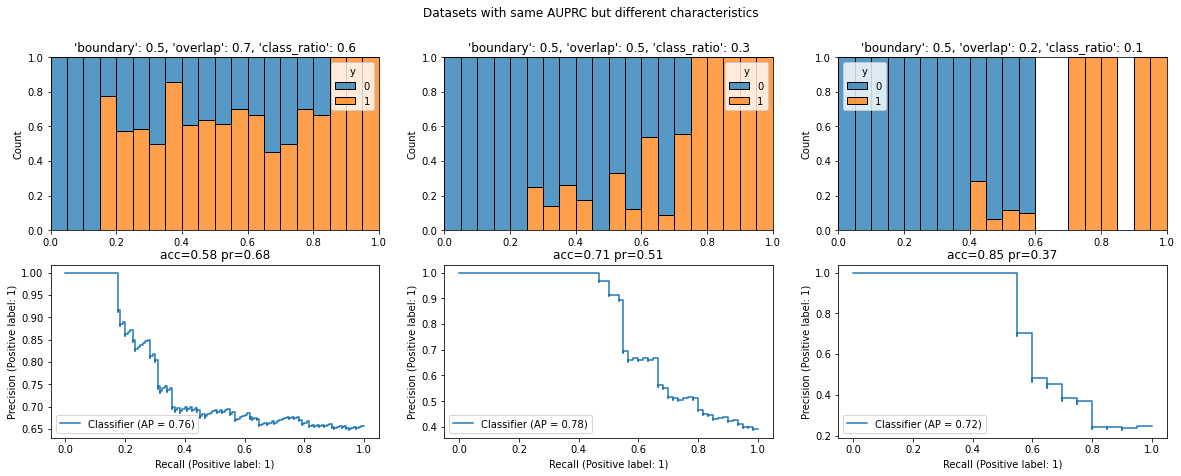

In [67]:
examples = [
    {"boundary": 0.5, "overlap": 0.7, "class_ratio": 0.6},
    {"boundary": 0.5, "overlap": 0.5, "class_ratio": 0.3},
    {"boundary": 0.5, "overlap": 0.2, "class_ratio": 0.1},
]

fig, axarr = plt.subplots(2, len(examples), figsize=(20,7), sharex=False)
plt.suptitle("Datasets with same AUPRC but different characteristics")
for ix, params in enumerate(examples):
    data = get_data(**params, dist="uniform")
    plot_data(data, ax=axarr[0, ix], title=str(params)[1:-1], dist="uniform")
    axarr[0, ix].set_xlabel("")
    
    axarr[1, ix].set_title(f"acc={sk_metrics.accuracy_score(data['y'], data['preds'] > 0.5):.2f} pr={sk_metrics.precision_score(data['y'], data['preds'] > 0.5):.2f}")
    sk_metrics.PrecisionRecallDisplay.from_predictions(y_true=data["y"], y_pred=data["preds"], ax=axarr[1, ix])
plt.show()


# 5. Conclusion
- AUROC provides an expected precision over all splits of the positive class
- The underlying metric PPV, is senstive to class imbalance
- The underlying axis TPR, zooms in on regions with most positive densitiy
- AUROC is invariant to location, size or shape of the positive class
- AUROC is sensitive how much predictions overlap and class imbalance